# Evidence curve as a function of time

This notebook examines how well the evidence curve can help us constrain the start time of a QNM. We consider an ideal case where a $(l=2,m=2,n=0)$ mode is injected into white noise.

In [45]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [46]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import copy

## GW150914 - finding alignment

In [47]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147+0.0*1e-3,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

delta_mass = 0.2
delta_chi = 0.005
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)


index_spacing = 1
num_iteration = 3000
initial_offset = -2000

In [48]:
fit_L = qnm_filter.Network(**input)
fit_L.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit_L.detector_alignment()
fit_L.condition_data('original_data', **input)
fit_L.compute_acfs('original_data')
fit_L.cholesky_decomposition()

fit_L.first_index()
t_arr, evidence_arr_L = qnm_filter.evidence_parallel(fit_L, index_spacing, num_iteration, 
                                                   initial_offset, massspace, chispace, 
                                                   num_cpu = 9, verbosity=False, 
                                                   apply_filter=False, 
                                                   model_list = [(2, 2, 0)])

evidence_arr_L /= np.log(10)

In [49]:
fit_H = qnm_filter.Network(**input)
fit_H.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit_H.detector_alignment()
fit_H.condition_data('original_data', **input)
fit_H.compute_acfs('original_data')
fit_H.cholesky_decomposition()

fit_H.first_index()
t_arr, evidence_arr_H = qnm_filter.evidence_parallel(fit_H, index_spacing, num_iteration, 
                                                   initial_offset, massspace, chispace, 
                                                   num_cpu = 9, verbosity=False, 
                                                   apply_filter=False, 
                                                   model_list = [(2, 2, 0)])

evidence_arr_H /= np.log(10)

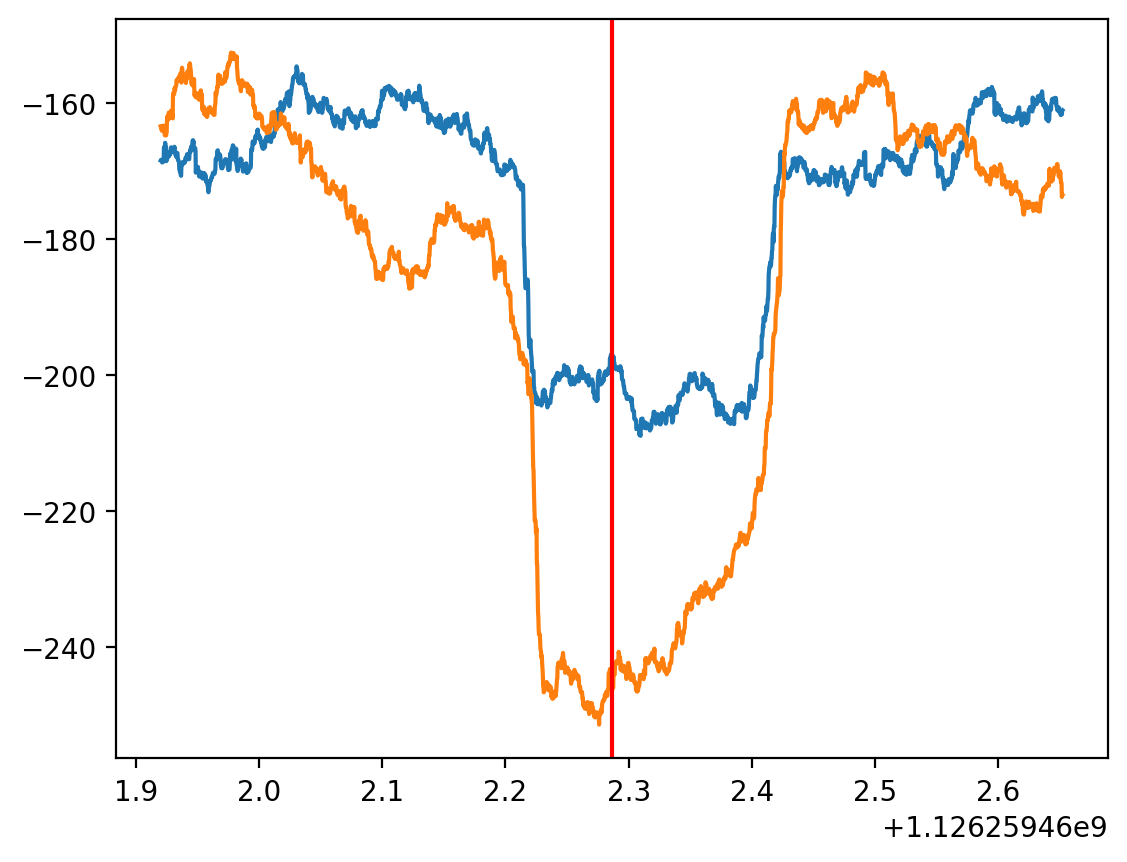

In [50]:
pl.plot(t_arr, evidence_arr_L)
pl.plot(t_arr, evidence_arr_H)
pl.axvline(t_arr[idx], c = 'r')

In [51]:
L_max = max(evidence_arr_L)
L_min = min(evidence_arr_L)
L_diff = L_max - L_min
H_max = max(evidence_arr_H)
H_min = min(evidence_arr_H)
H_diff = H_max - H_min
H_scaled = L_diff/H_diff*evidence_arr_H + (L_min - L_diff/H_diff*H_min)

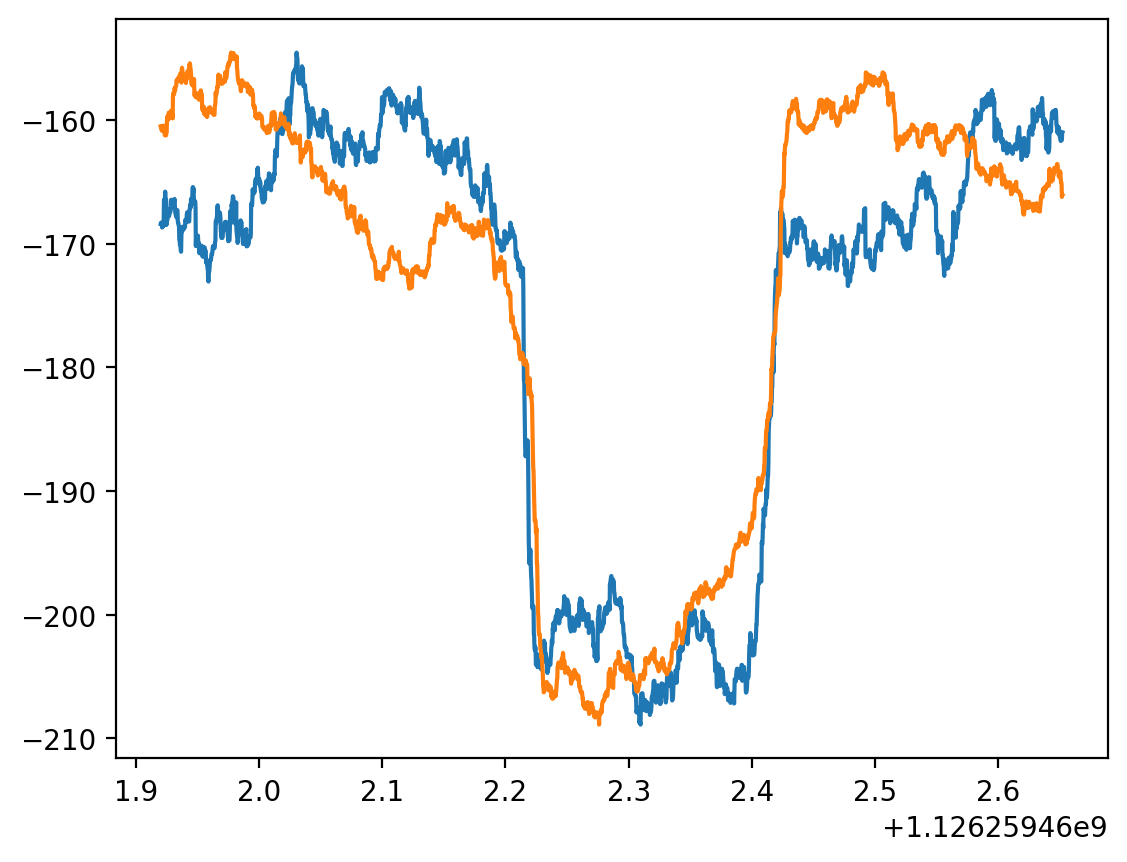

In [52]:
pl.plot(t_arr, evidence_arr_L)
pl.plot(t_arr, H_scaled)

In [55]:
corr = np.correlate(evidence_arr_L, evidence_arr_H, mode = "same")
idx = np.argmax(corr)

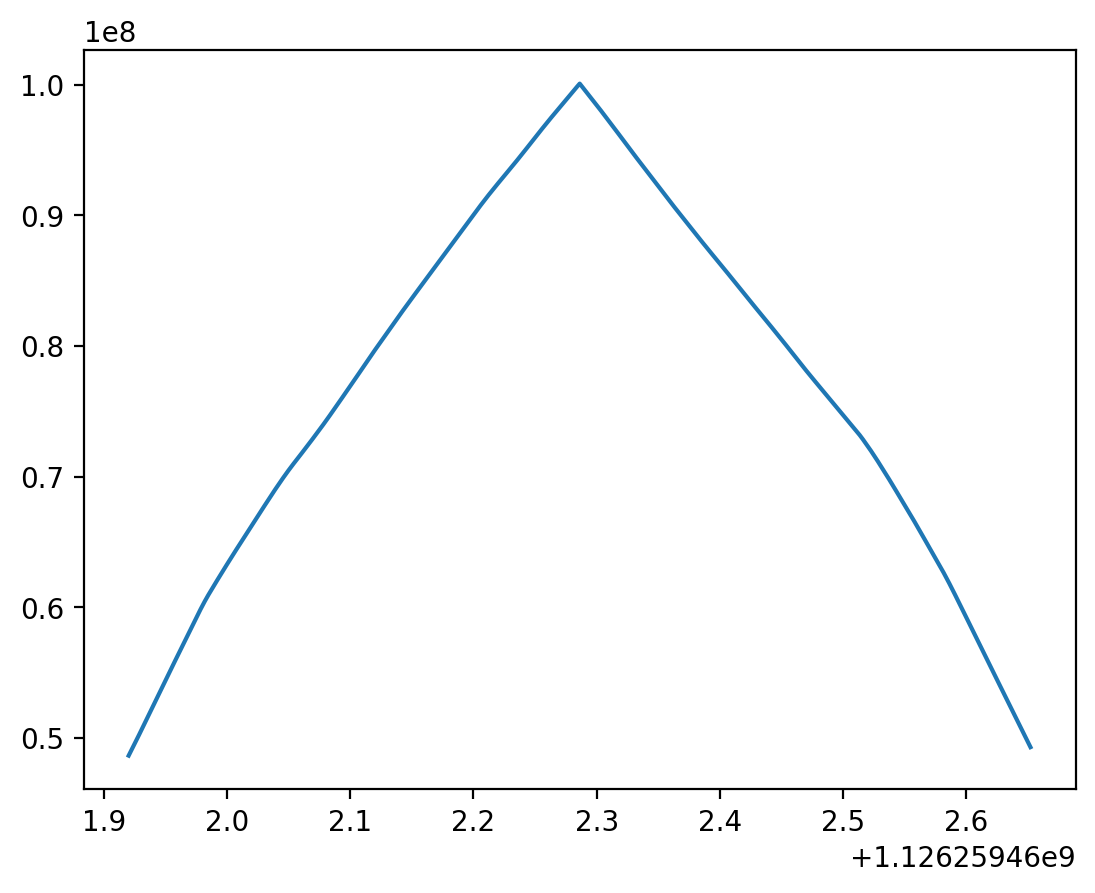

In [56]:
pl.plot(t_arr, corr)

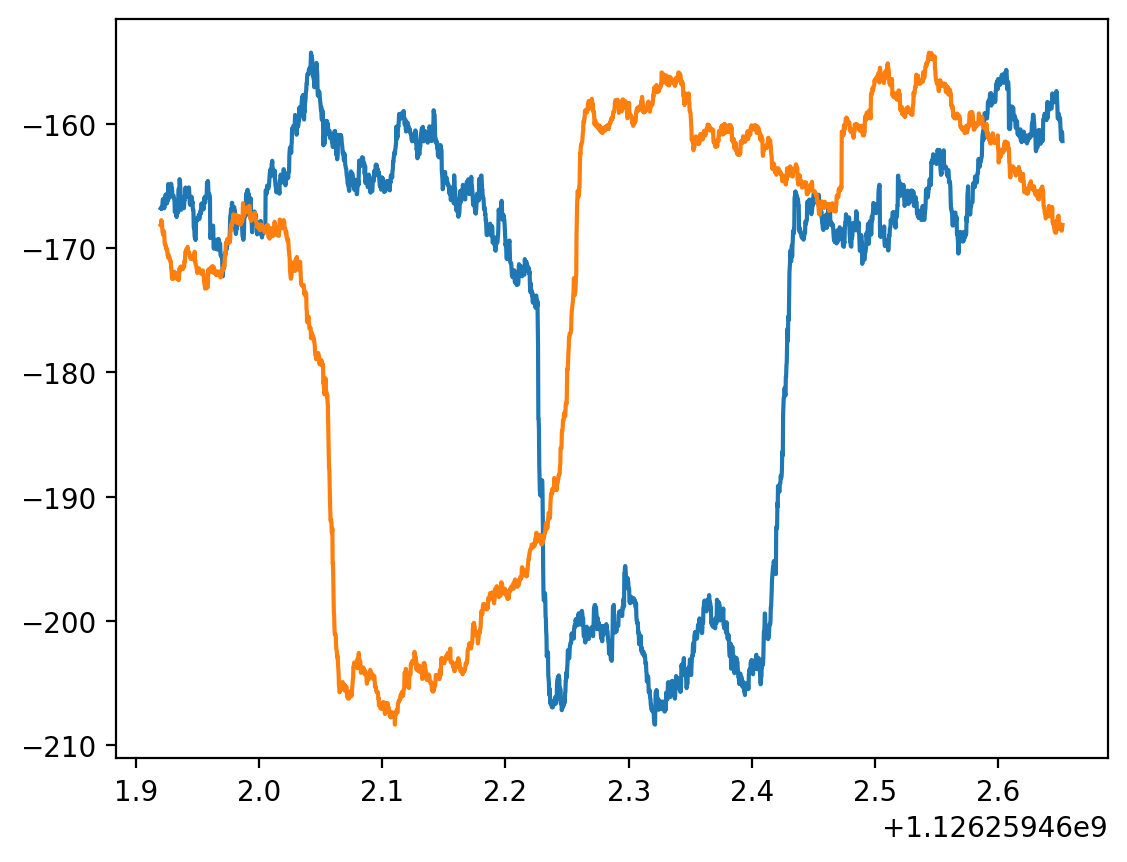

In [37]:
roll_no = np.argmax(corr)
pl.plot(t_arr, evidence_arr_L)
pl.plot(t_arr, np.roll(H_scaled, -roll_no))

In [134]:
L_max = max(evidence_arr_L)
L_min = min(evidence_arr_L)
L_diff = L_max - L_min
H_max = max(evidence_arr_H)
H_min = min(evidence_arr_H)
H_diff = H_max - H_min
H_scaled = L_diff/H_diff*evidence_arr_H + (L_min - L_diff/H_diff*H_min)

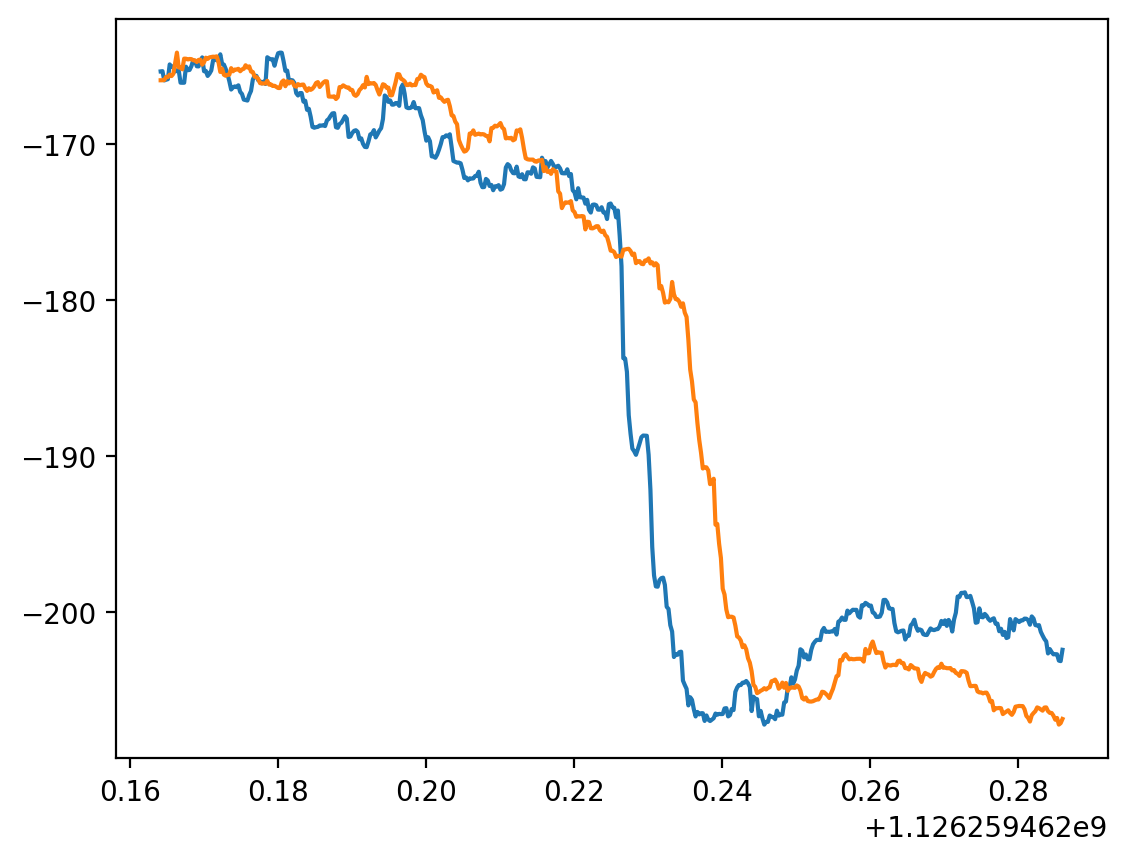

In [135]:
pl.plot(t_arr, evidence_arr_L)
pl.plot(t_arr, H_scaled)

In [32]:
def my_corr(x, y):
    result = np.zeros(len(x))
    for i in range(len(x)):
        temp = np.roll(y, -i)
        diff = np.abs(x[200:400] - temp[200:400])
        result[i] = 1/diff.sum()
    return result

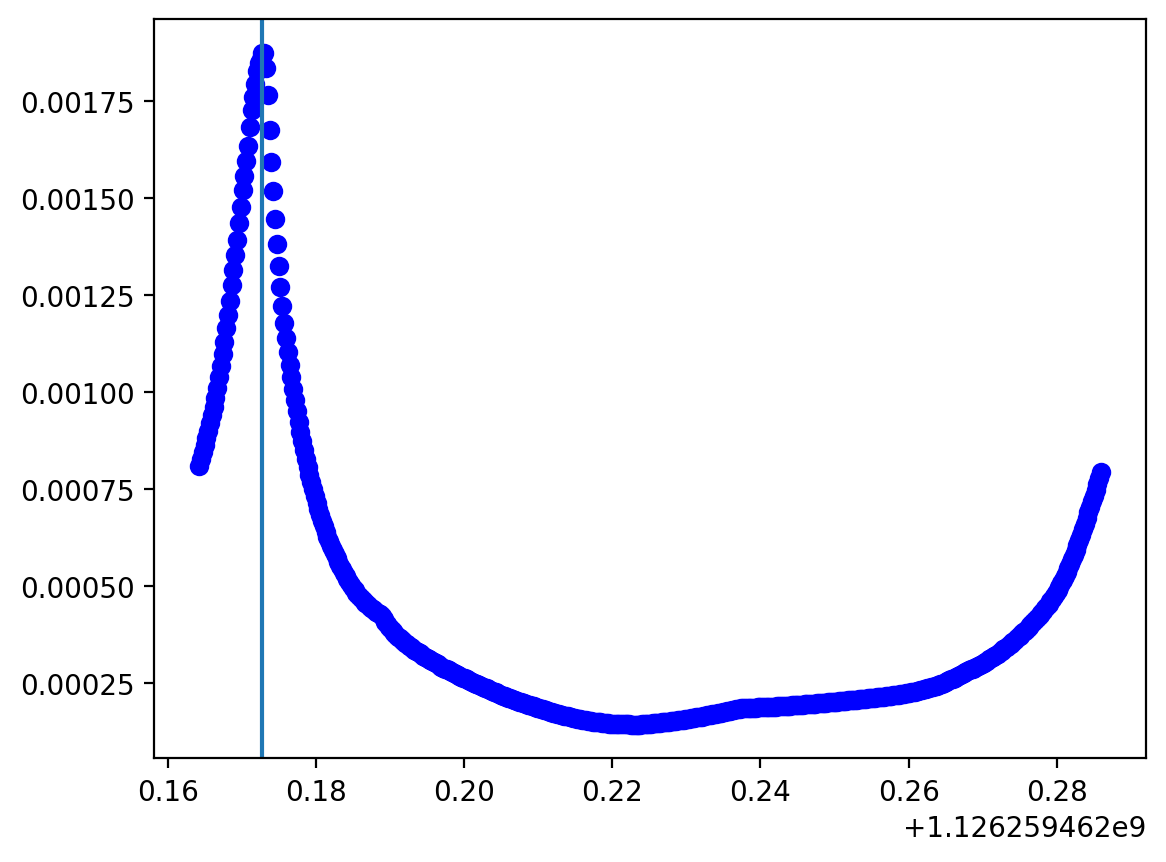

In [137]:
corr = my_corr(evidence_arr_L, H_scaled)
pl.plot(t_arr, corr, 'bo')
pl.axvline(t_arr[np.argmax(corr)])

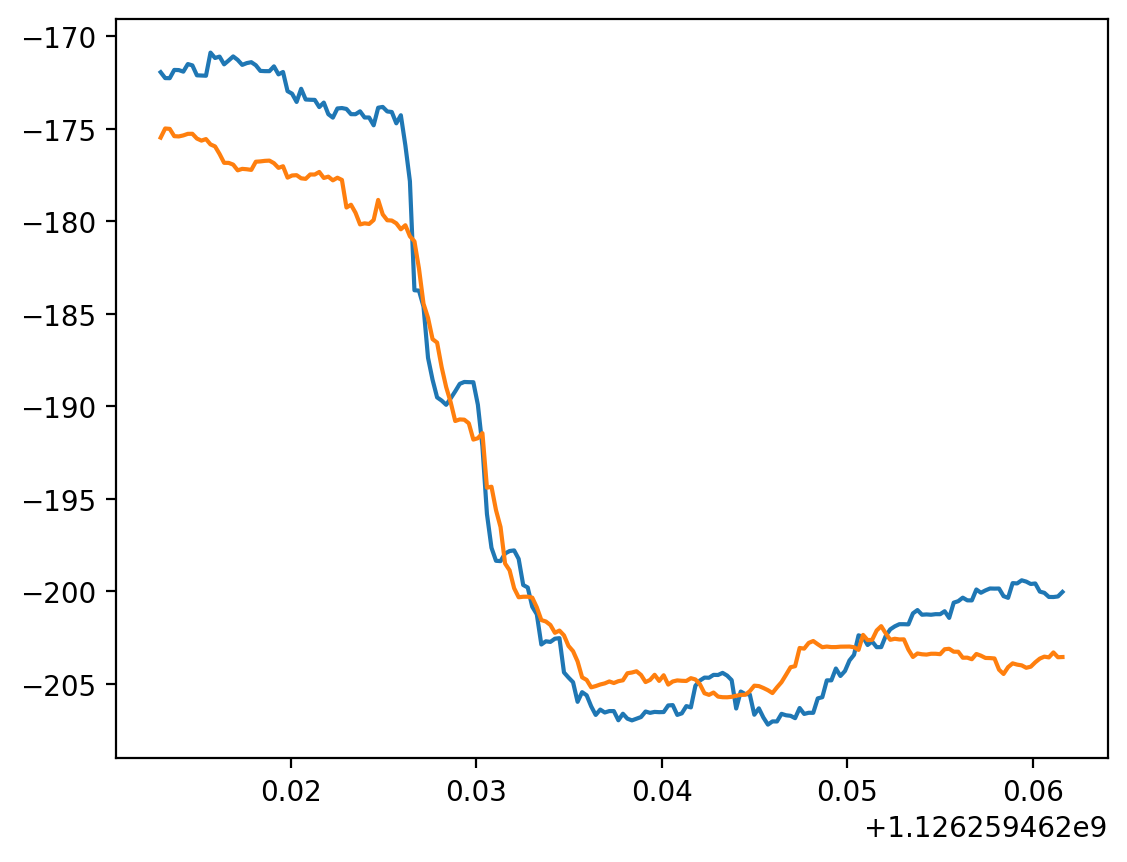

In [138]:
roll_no = np.argmax(corr)
pl.plot(t_arr[200:400], evidence_arr_L[200:400])
pl.plot(t_arr[200:400], np.roll(H_scaled, -roll_no)[200:400])

In [144]:
time_delay = t_arr[roll_no] - t_arr[0]
print(time_delay)

0.008544921875


## Using alignment

In [140]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147+2.0*1e-3,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

In [141]:
fit = qnm_filter.Network(**input)
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')

In [145]:
fit.t_init

1126259462.4103148

In [146]:
L_offset = 0.0077
fit.start_times['L1'] = fit.t_init + L_offset
fit.start_times['H1'] = fit.t_init + L_offset + time_delay

In [147]:
fit.condition_data('original_data', **input)
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

In [148]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

Text(0, 0.5, '$\\chi_f$')

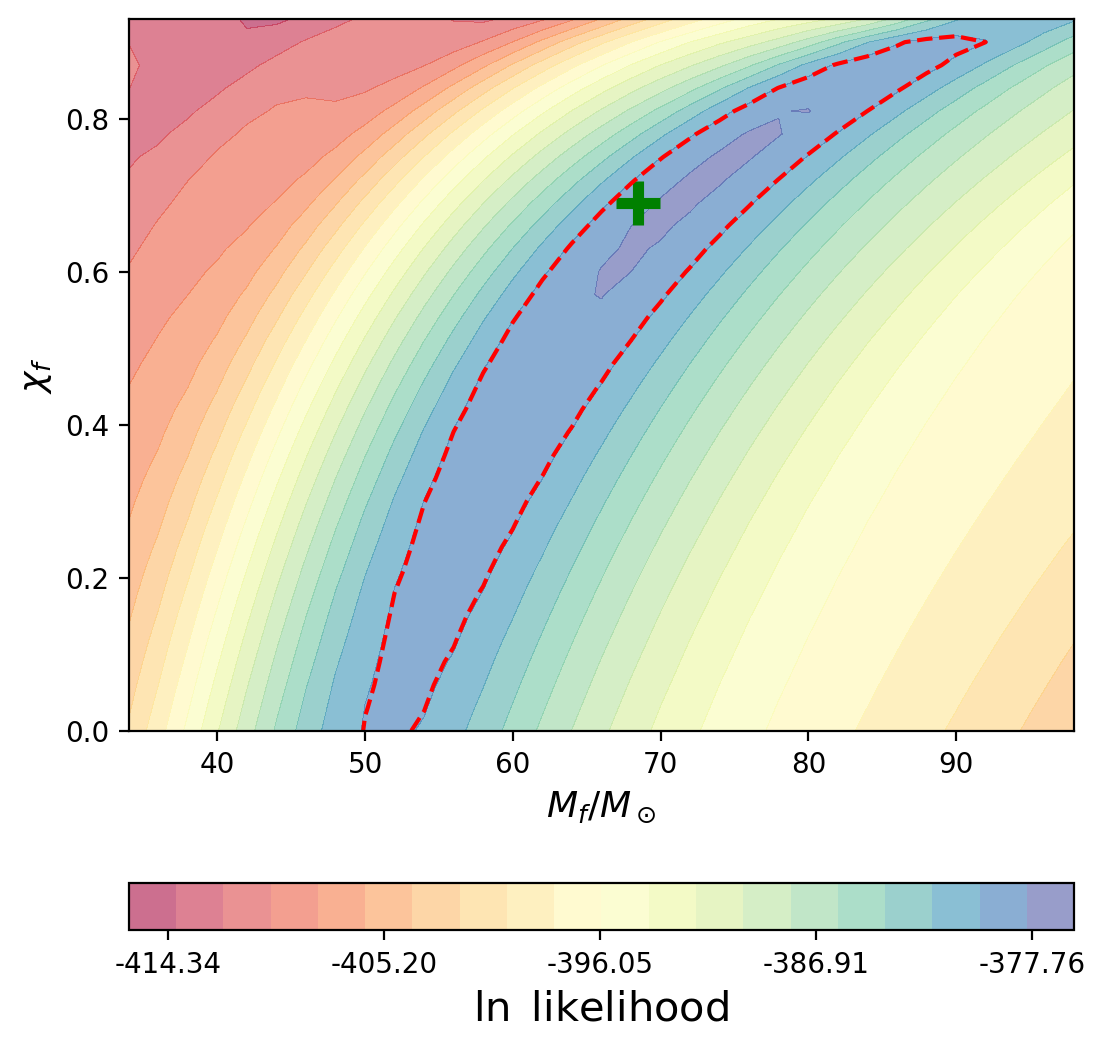

In [149]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')